In [4]:
import os
import numpy as np
import jax 
import matplotlib.pyplot as plt
import pickle
from nadaray_watson_ce import nadaraya_watson_ece, dirichlet_calibration_error
from projected_ce import top_calibration_error, class_wise_calibration_error, projected_calibration_error
from utils import median_heuristic
import jax.numpy as jnp
from tqdm import tqdm
from rkhs_ce import kernel_calibration_error
from synth_data import generative_model

In [5]:
# Function to save results
def save_results(results, filename="calibration_experiment_results.pkl"):
    with open(filename, "wb") as f:
        pickle.dump(results, f)
    print(f"Results saved to {filename}")

# Function to load results
def load_results(filename="calibration_experiment_results.pkl"):
    if os.path.exists(filename):
        with open(filename, "rb") as f:
            return pickle.load(f)
    else:
        raise FileNotFoundError(f"File {filename} does not exist.")

In [6]:
# Function to plot results
def plot_results(all_results):
    methods = list(next(iter(all_results.values())).keys())
    models = list(all_results.keys())
    colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]  # Custom colors similar to original paper

    fig, axes = plt.subplots(len(models), len(methods), figsize=(12, 8), sharex=True, sharey=True)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, model in enumerate(models):
        for j, method in enumerate(methods):
            ax = axes[i, j] if len(models) > 1 else axes[j]
            data = all_results[model][method]
            mean_error = np.mean(data)
            min_error = np.min(data)
            max_error = np.max(data)

            # Custom style for histograms
            ax.hist(data, bins=20, color=colors[j % len(colors)], edgecolor='black', alpha=0.75, density=True)

            # Add vertical lines for mean, min, and max
            ax.axvline(mean_error, color='black', linestyle='-', linewidth=1.5, label='Mean')
            ax.axvline(min_error, color='grey', linestyle='--', linewidth=1, label='Min')
            ax.axvline(max_error, color='grey', linestyle='--', linewidth=1, label='Max')

            # Set titles and labels
            if i == 0:
                ax.set_title(f"{method.replace('_', ' ').title()}", fontsize=10)
            if j == 0:
                ax.set_ylabel(f"{model}", fontsize=10)
            if i == len(models) - 1:
                ax.set_xlabel("Calibration Error", fontsize=10)

    # Add common legend
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper center", bbox_to_anchor=(0.5, 1.02), ncol=3, fontsize=9)

    plt.tight_layout()
    plt.show()



# Main experimental function
def run_experiments(key,num_runs: int,calibration_methods:dict,model_fun , pi1: float, pi2: float, pi3: float):
    
    
    methods_name = list(calibration_methods.keys())
    all_results = {"M1": {m:[] for m in methods_name},
                   "M2": {m:[] for m in methods_name},
                   "M3": {m:[] for m in methods_name}}
    
    models = {
        "M1": lambda key: model_fun(key,pi1), 
        "M2": lambda key: model_fun(key,pi2),
        "M3": lambda key: model_fun(key,pi3),
    }
    
    
    for run in tqdm(range(num_runs)):
        for method_name,method_fun in calibration_methods.items():
            for gen_model_name, gen_model in models.items():    
                key, _ = jax.random.split(key, 2)
                g_X, Z, Y  = gen_model(key)                
                if "random" in method_name:
                    key, _ = jax.random.split(key,2)
                    error = method_fun(key, g_X, Y)
                else:
                    error = method_fun(g_X, Y)
                    
                all_results[gen_model_name][method_name].append(error)
    return all_results

In [ ]:
def eval_routine():
    pass 


key = jax.random.PRNGKey(0)
params = {
    'num_runs' :100,
    "n_samples": 1000,
    "dim": 10,
    "alpha": 1 * jnp.ones(10,),
    "beta": (1/10) * jnp.ones(10,),
    "kernelized": False,
    "num_bins": 20,
    "equal_size": False,
    "num_proj": 100,
    'pi1':0.00,
    'pi2':0.1,
    'pi3':0.5,
    'sigma':0.1
}


kernel_fun = lambda x, y : jnp.exp(-(jnp.linalg.norm(x-y)/params['sigma'])**2)
kernel_fun = jax.vmap(kernel_fun, (0,None), 0)
kernel_fun = jax.vmap(kernel_fun, (None, 0), 1)


 
calibration_methods = {
        "top_class": lambda probs, labels: top_calibration_error(probs, labels, num_bins=params['num_bins'], equal_size=params['equal_size']),
        'kernel_cal':lambda probs, labels: kernel_calibration_error(probs, labels, kernel_fun),
        "random_projected": lambda key, probs, labels: projected_calibration_error(key, probs, labels, num_bins=params['num_bins'] ,  equal_size=params['equal_size'], num_proj=params['num_proj'])
    }

jitted_calibration_methods = {k:jax.jit(calibration_methods[k]) for k in calibration_methods.keys()}


model_fun  = lambda key, pi :generative_model(key,params['alpha'],params['beta'],pi=pi,n_samples=params['n_samples'])


results = run_experiments(jax.random.key(42),params['num_runs'],calibration_methods,model_fun,params['pi1'], params['pi2'], params['pi3'])


100%|██████████| 100/100 [01:19<00:00,  1.26it/s]


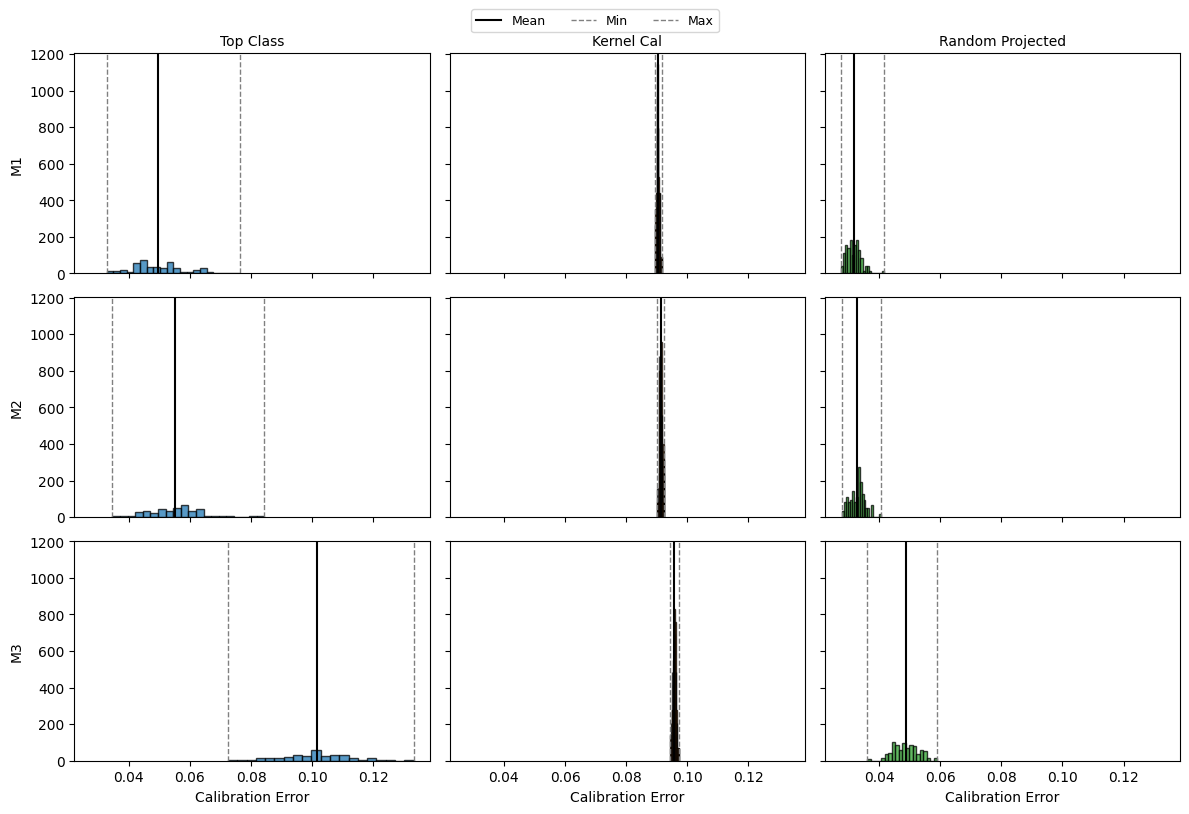

In [7]:
plot_results(results)


In [24]:


# Example usage
key = jax.random.PRNGKey(0)
params = {
    'num_runs' :100,
    "n_samples": 1000,
    "dim": 10,
    "alpha": 1 * jnp.ones(10,),
    "beta": (1/10) * jnp.ones(10,),
    "kernelized": False,
    "num_bins": 20,
    "equal_size": False,
    "num_proj": 100,
    'pi1':0.00,
    'pi2':0.3,
    'pi3':0.0,
    'sigma':0.1
}

def get_kernel_fun(sigma):
    kernel_fun = lambda x, y : jnp.exp(-(jnp.linalg.norm(x-y)/sigma)**2)
    kernel_fun = jax.vmap(kernel_fun, (0,None), 0)
    kernel_fun = jax.vmap(kernel_fun, (None, 0), 1)
    return kernel_fun

 
calibration_methods = {
        # "top_class": lambda probs, labels: top_calibration_error(probs, labels, num_bins=params['num_bins'], equal_size=params['equal_size']),
        # 'kernel_cal_sigma1':lambda probs, labels: kernel_calibration_error(probs, labels, get_kernel_fun(0.01)),
        # 'kernel_cal_sigma2':lambda probs, labels: kernel_calibration_error(probs, labels, get_kernel_fun(0.1)),
        # 'kernel_cal_sigma3':lambda probs, labels: kernel_calibration_error(probs, labels, get_kernel_fun(0.2)),
        'kernel_cal_sigma4':lambda probs, labels: kernel_calibration_error(probs, labels, get_kernel_fun(1)),

        'kernel_cal_sigma5':lambda probs, labels: kernel_calibration_error(probs, labels, get_kernel_fun(2)),
        # 'kernel2_cal':lambda probs, labels: kernel_calibration_error(probs, labels, kernel_fun),
        # "random_projected": lambda key, probs, labels: projected_calibration_error(key, probs, labels, num_bins=params['num_bins'] ,  equal_size=params['equal_size'], num_proj=params['num_proj'])
    }

jitted_calibration_methods = {k:jax.jit(calibration_methods[k]) for k in calibration_methods.keys()}


model_fun  = lambda key, pi :generative_model(key,params['alpha'],params['beta'],pi=pi,n_samples=params['n_samples'])


results = run_experiments(jax.random.key(42),params['num_runs'],jitted_calibration_methods,model_fun,params['pi1'], params['pi2'], params['pi3'])


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:08<00:00, 12.02it/s]


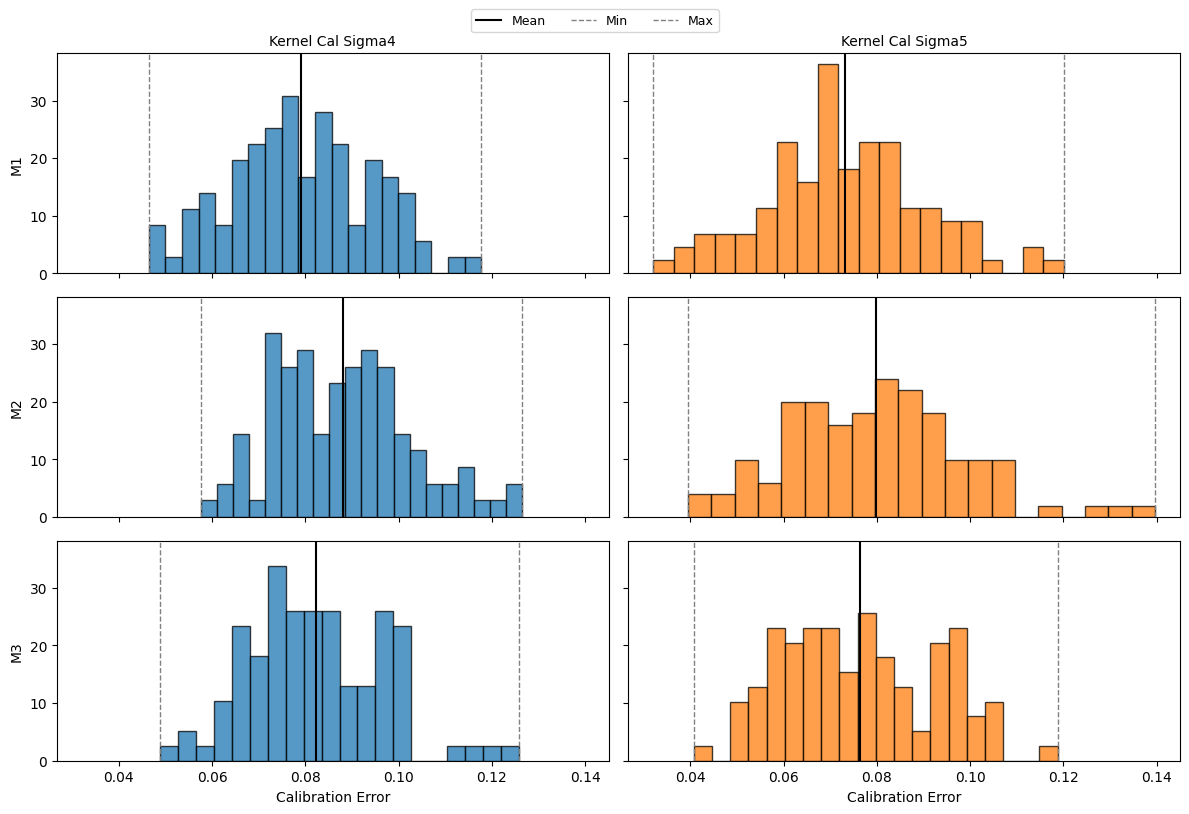

In [25]:
plot_results(results)
